In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [5]:
df.shape

(299, 13)

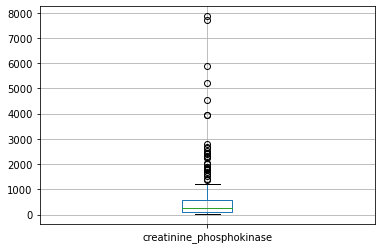

In [6]:
df.boxplot(column = ['creatinine_phosphokinase'])

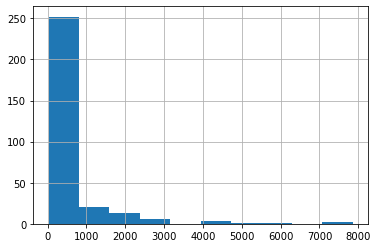

In [7]:
df.creatinine_phosphokinase.hist()

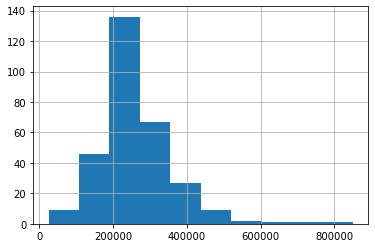

In [8]:
df.platelets.hist()

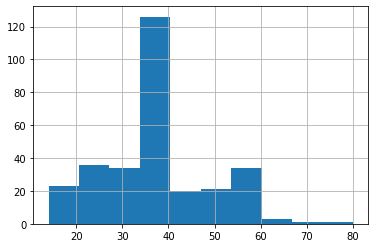

In [12]:
df.ejection_fraction.hist();

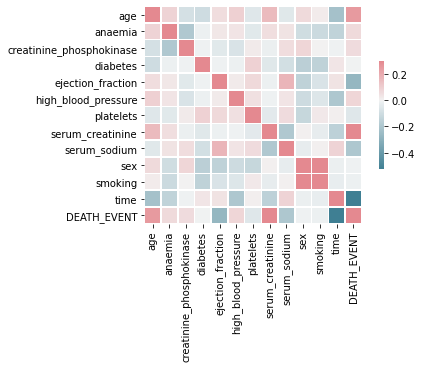

In [10]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(),vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
df.corr()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.088006,-0.081584,-0.101012,0.060098,0.093289,-0.052354,0.159187,-0.045966,0.065430,0.018668,-0.224068,0.253729
anaemia,0.088006,1.000000,-0.190741,-0.012729,0.031557,0.038182,-0.043786,0.052174,0.041882,-0.094769,-0.107290,-0.141414,0.066270
creatinine_phosphokinase,-0.081584,-0.190741,1.000000,-0.009639,-0.044080,-0.070590,0.024463,-0.016408,0.059550,0.079791,0.002421,-0.009346,0.062728
diabetes,-0.101012,-0.012729,-0.009639,1.000000,-0.004850,-0.012732,0.092193,-0.046975,-0.089551,-0.157730,-0.147173,0.033726,-0.001943
ejection_fraction,0.060098,0.031557,-0.044080,-0.004850,1.000000,0.024445,0.072177,-0.011302,0.175902,-0.148386,-0.067315,0.041729,-0.268603
high_blood_pressure,0.093289,0.038182,-0.070590,-0.012732,0.024445,1.000000,0.049963,-0.004935,0.037109,-0.104615,-0.055711,-0.196439,0.079351
platelets,-0.052354,-0.043786,0.024463,0.092193,0.072177,0.049963,1.000000,-0.041198,0.062125,-0.125120,0.028234,0.010514,-0.049139
serum_creatinine,0.159187,0.052174,-0.016408,-0.046975,-0.011302,-0.004935,-0.041198,1.000000,-0.189095,0.006970,-0.027414,-0.149315,0.294278
serum_sodium,-0.045966,0.041882,0.059550,-0.089551,0.175902,0.037109,0.062125,-0.189095,1.000000,-0.027566,0.004813,0.087640,-0.195204
sex,0.065430,-0.094769,0.079791,-0.157730,-0.148386,-0.104615,-0.125120,0.006970,-0.027566,1.000000,0.445892,-0.015608,-0.004316


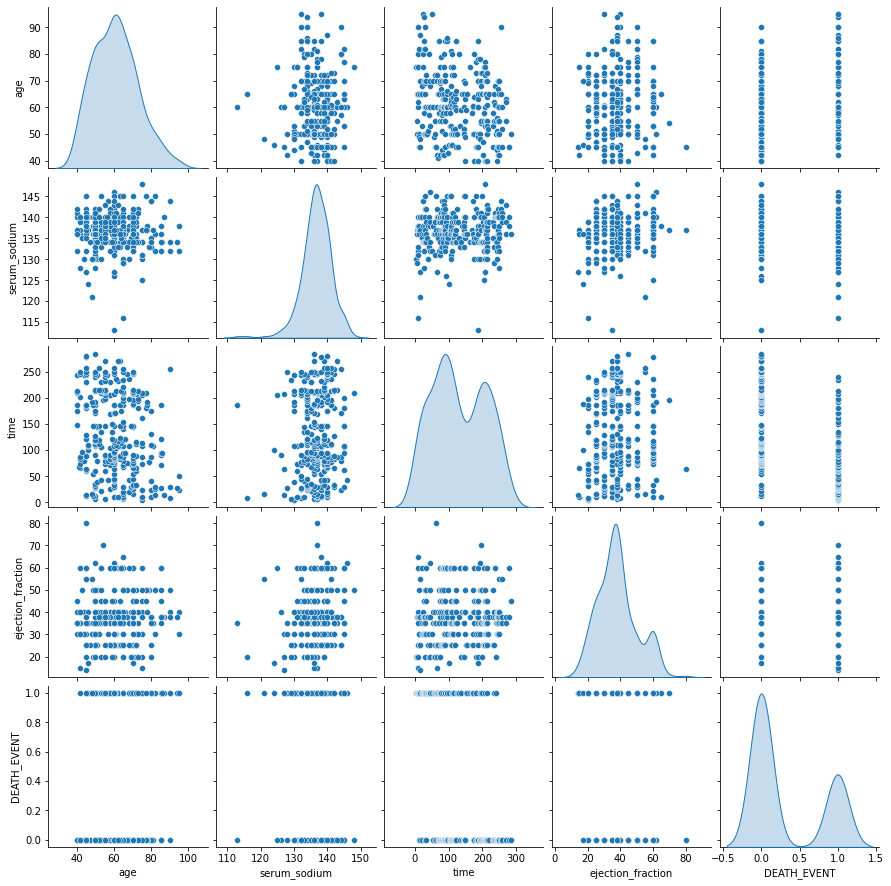

In [53]:
sns.pairplot(df[['age','serum_sodium','time','ejection_fraction','DEATH_EVENT']], diag_kind='kde')

In [5]:
target = df.pop('DEATH_EVENT')
target

0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: DEATH_EVENT, Length: 299, dtype: int64

In [9]:
x=df.values
x=StandardScaler().fit_transform(x)
y=target.values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [11]:
principalDf.head()

,principal component 1,principal component 2
0,0.877055,2.287104
1,1.863753,-1.552894
2,2.526429,1.369821
3,0.579566,1.143232
4,-0.960485,2.639384


In [93]:
X_train, X_val, y_train, y_val = train_test_split(df,target, test_size=0.15, random_state=42)
#X_train=(X_train-X_train.mean())/X_train.std()
#y_train=(y_train-y_train.mean())/y_train.std()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(df)).batch(4)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(4)

In [74]:
for feat, targ in train_dataset.take(1):
    print ('Features: {}, Target: {}'.format(feat, targ))

Features: [[6.20e+01 0.00e+00 2.31e+02 0.00e+00 2.50e+01 1.00e+00 2.53e+05 9.00e-01
  1.40e+02 1.00e+00 1.00e+00 1.00e+01 1.00e+00]
 [5.30e+01 1.00e+00 5.82e+02 0.00e+00 4.50e+01 0.00e+00 3.05e+05 1.10e+00
  1.37e+02 1.00e+00 1.00e+00 2.09e+02 0.00e+00]
 [5.80e+01 1.00e+00 6.00e+01 0.00e+00 3.80e+01 0.00e+00 1.53e+05 5.80e+00
  1.34e+02 1.00e+00 0.00e+00 2.60e+01 1.00e+00]
 [6.30e+01 1.00e+00 1.03e+02 1.00e+00 3.50e+01 0.00e+00 1.79e+05 9.00e-01
  1.36e+02 1.00e+00 1.00e+00 2.70e+02 0.00e+00]], Target: [1 0 1 0]


In [75]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [94]:
model = get_compiled_model()
model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
64/64 [==============================] - 1s 5ms/step - loss: 8824.2012 - accuracy: 0.6378 - val_loss: 493.7781 - val_accuracy: 0.5778
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 291.4567 - accuracy: 0.6063 - val_loss: 521.3340 - val_accuracy: 0.5778
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 228.8157 - accuracy: 0.5984 - val_loss: 174.9285 - val_accuracy: 0.5333
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 175.7275 - accuracy: 0.6299 - val_loss: 60.7250 - val_accuracy: 0.5778
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 139.6601 - accuracy: 0.5906 - val_loss: 50.4120 - val_accuracy: 0.5778
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 116.7659 - accuracy: 0.5748 - val_loss: 124.2799 - val_accuracy: 0.4444
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 173.6871 - accuracy: 0.5787 - val_loss: 50.5032 - val_accuracy: 0

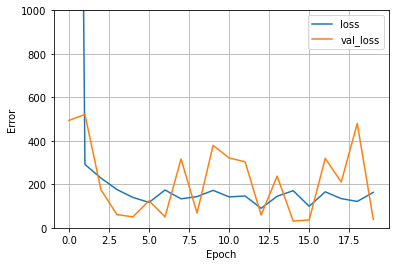

In [96]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1000])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
plot_loss(model.history)